In [1]:
%matplotlib notebook

from IPython.display import Image

from sdss import SDSS
import mikkel_tools.utility as mt_util
import plot as sds_plt

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import pyshtools
import pickle

comment = "Showcase VRE workflow with SDSSIM"
nb_name = "nb_seqsim_core_swarm_dqw"

## Forward problem

In spherical geometry, given observations, d(__r__), and model parameters on a spherical surface, m(__s__), related through an integrating kernel $\mathcal{G}$(__r__,__s__) we consider a linear inverse problem of the form

d(__r__) = $\int_{S} \mathcal{G}$(__r__,__s__) m(__s__) dS

Where $dS = \sin \theta_s d\theta_s d\phi_s$, with __r__ = $(r,\theta,\phi)$ indicating locations of the observations, and __s__ = $(R,\theta_s,\phi_s)$ indicating locations of the model parameters on a spherical surface of radius $R$.

## Integrating kernel

Exterior Neumann Green's function description linking the radial geomagnetic field at an observation location, __r__, to the radial field at a source location, __s__.

$G_r = \frac{1}{4 \pi} \frac{h^2 (1-h^2)}{f^3}$

Where

$
h =\frac{R}{r}, \quad f = \frac{\sqrt{r^2+R^2-2r R\mu}}{r}\\
\mu = \cos\theta \cos\theta_s \sin\theta \sin\theta_s\cos(\phi-\phi_s)
$

## Goal

Estimate posterior pdf __m__, which is an ensemble of vector model parameter values on the spherical surface grid. Estimation is based on observed data and prior information on the model parameters.

## Method 
#### Direct Sequential Simulation in spherical geometry

Geostatistical method usually used in underground natural resource exploration which, as far as the observations allow, reproduces
- Prior covariance model
- Training image histogram

In [2]:
shn = 30
C_e_const = 2.0

core = SDSS(comment, N_SH = shn, sim_type = "core", sat_height = 350)

core.grid_glq(nmax = shn, r_at = core.r_cmb)

grid_in = np.array([core.grid_phi, 90-core.grid_theta]).T
core.make_grid(core.r_cmb, grid_in, calc_sph_d = True)

core.generate_map(target_var_factor = 1)

core.condtab(normsize=1000, quantiles = 100, 
             rangn_lim = 3.5, rangn_N = 101, rangv_lim = 2.0, rangv_N = 101)

core.semivar(model_lags = "all", model = "exponential", max_dist = 20000, lag_length = 200,
             zero_nugget = True, hit_target_var = True)


____semi-variogram setup___

Number of data used: 3575881
Max data distance: 10919.075 km
Lag length chosen: 200.0 km
Number of lags: 54
Number of modelling lags: all

Semi-variogram model determined, starting LUT computation



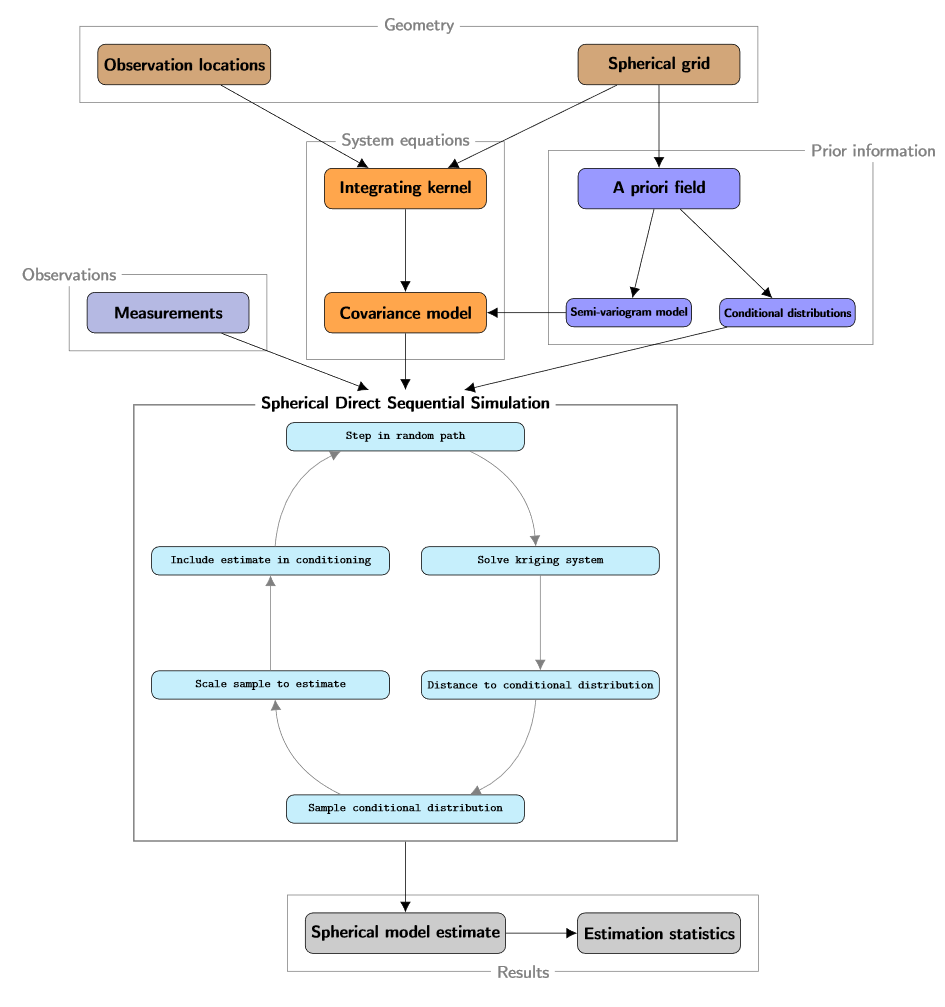

In [3]:
Image(filename='images/sdssim_outline.png') 

<IPython.core.display.Javascript object>


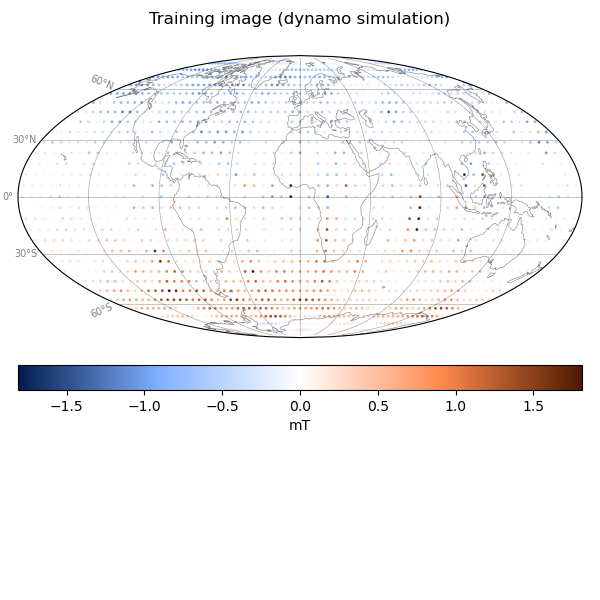

In [4]:
mt_util.plot_global(lat = core.lat, lon = core.lon, data=core.data, 
                cbar_h = 0.075, cbar_mm_factor = 2/3, unit_transform_n_to_m = True,
                cbar_text = "mT", figsize=(6,6), coast_width = 0.4,
                bottom=0.35, top=0.95, hspace=0.01,
                title='Training image (dynamo simulation)', point_size=1,
                savefig = False, save_dpi = 100, save_string ="vre_obs_TI",
                use_gridlines = True, gridlines_width = 0.4, gridlines_alpha = 0.4)

<IPython.core.display.Javascript object>


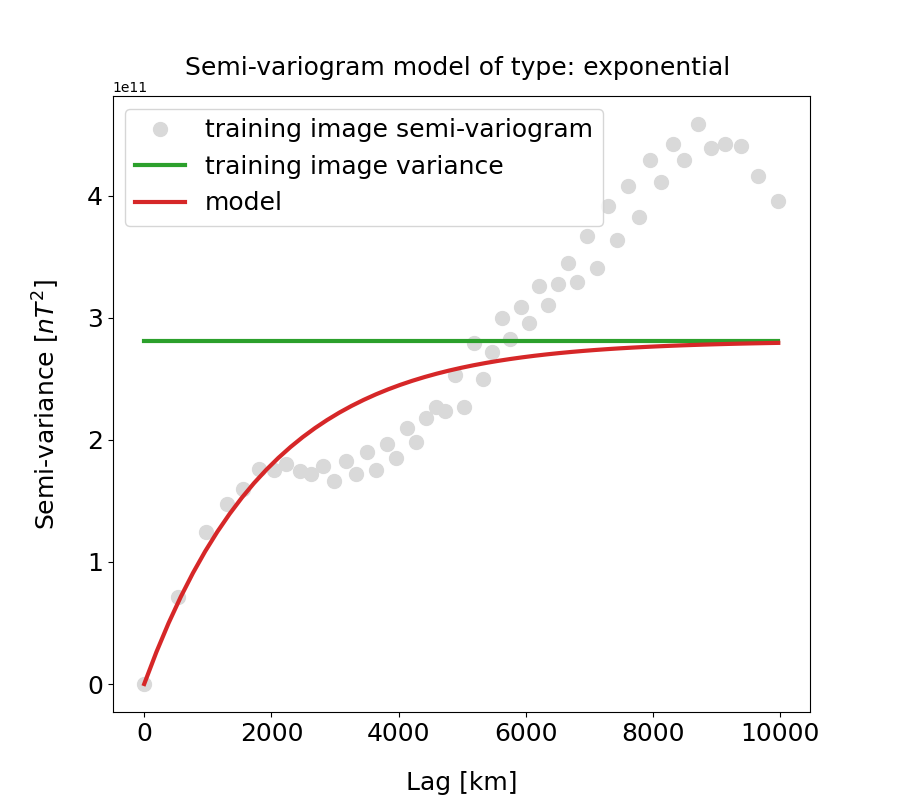

In [5]:
#%% PLOT SEMI-VARIOGRAM
plt.figure(figsize=(9,8)) 
plt.plot(core.lags,core.pics,'o', markersize=10,color = '0.85',label='training image semi-variogram')
plt.plot(core.lags_sv_curve,np.ones(core.lags_sv_curve.shape)*core.target_var,linewidth = 3, color="C2", label="training image variance")
plt.plot(core.lags_sv_curve,core.sv_curve,color='C3', linewidth = 3,label='model')
plt.ylabel('Semi-variance $[%s^2]$' % "nT",fontsize=18,labelpad=18)
plt.xlabel('Lag [km]',fontsize=18,labelpad=18)
plt.title("Semi-variogram model of type: %s " % core.model_names[core.model],fontsize=18,y=1.02)
plt.legend(loc='best',fontsize=18)
ax = plt.gca()
ax.tick_params(axis = 'both', which = 'major', labelsize = 18)
plt.show()

# Swarm observations through VRE

In [6]:
import datetime as dt
from viresclient import SwarmRequest

request = SwarmRequest()

In [7]:
collect = "SW_OPER_MAGA_LR_1B"

In [8]:
request.available_measurements("MAG")

['F',
 'dF_AOCS',
 'dF_other',
 'F_error',
 'B_VFM',
 'B_NEC',
 'dB_Sun',
 'dB_AOCS',
 'dB_other',
 'B_error',
 'q_NEC_CRF',
 'Att_error',
 'Flags_F',
 'Flags_B',
 'Flags_q',
 'Flags_Platform',
 'ASM_Freq_Dev']

In [9]:
use_meas = ["B_NEC"]

In [10]:
request.available_auxiliaries()

['Timestamp',
 'Latitude',
 'Longitude',
 'Radius',
 'Spacecraft',
 'OrbitDirection',
 'QDOrbitDirection',
 'SyncStatus',
 'Kp10',
 'Kp',
 'Dst',
 'F107',
 'IMF_BY_GSM',
 'IMF_BZ_GSM',
 'IMF_V',
 'F10_INDEX',
 'OrbitSource',
 'OrbitNumber',
 'AscendingNodeTime',
 'AscendingNodeLongitude',
 'QDLat',
 'QDLon',
 'QDBasis',
 'MLT',
 'SunDeclination',
 'SunHourAngle',
 'SunRightAscension',
 'SunAzimuthAngle',
 'SunZenithAngle',
 'SunLongitude',
 'SunVector',
 'DipoleAxisVector',
 'NGPLatitude',
 'NGPLongitude',
 'DipoleTiltAngle']

In [11]:
use_aux = ["SunZenithAngle", "Kp", "QDLat", "Dst"]

In [12]:
request.available_models(details=False)

['IGRF',
 'LCS-1',
 'MF7',
 'CHAOS-Core',
 'CHAOS-Static',
 'CHAOS-MMA-Primary',
 'CHAOS-MMA-Secondary',
 'MCO_SHA_2C',
 'MCO_SHA_2D',
 'MLI_SHA_2C',
 'MLI_SHA_2D',
 'MLI_SHA_2E',
 'MMA_SHA_2C-Primary',
 'MMA_SHA_2C-Secondary',
 'MMA_SHA_2F-Primary',
 'MMA_SHA_2F-Secondary',
 'MIO_SHA_2C-Primary',
 'MIO_SHA_2C-Secondary',
 'MIO_SHA_2D-Primary',
 'MIO_SHA_2D-Secondary',
 'AMPS',
 'MCO_SHA_2X',
 'CHAOS',
 'CHAOS-MMA',
 'MMA_SHA_2C',
 'MMA_SHA_2F',
 'MIO_SHA_2C',
 'MIO_SHA_2D',
 'SwarmCI']

In [13]:
use_models = ["M_use = 'LCS-1' + 'CHAOS-MMA-Primary' + 'CHAOS-MMA-Secondary' + 'MIO_SHA_2C'"]

In [14]:
request.set_collection(collect)

request.set_products(measurements=use_meas,
                     models = use_models,
                     auxiliaries=use_aux,
                     residuals=False,
                     sampling_step="PT5M")

data = request.get_between(start_time=dt.datetime(2016,1,1),
                           end_time=dt.datetime(2016,1,15))

[1/1] Processing:  100%|██████████|  [ Elapsed: 00:08, Remaining: 00:00 ]
      Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.477MB)


In [15]:
ds = data.as_xarray()
print(ds)

<xarray.Dataset>
Dimensions:         (NEC: 3, Timestamp: 4032)
Coordinates:
  * Timestamp       (Timestamp) datetime64[ns] 2016-01-01 ... 2016-01-14T23:55:00
  * NEC             (NEC) <U1 'N' 'E' 'C'
Data variables:
    Spacecraft      (Timestamp) object 'A' 'A' 'A' 'A' 'A' ... 'A' 'A' 'A' 'A'
    B_NEC_M_use     (Timestamp, NEC) float64 -22.99 -1.688 -67.5 ... 4.589 9.819
    QDLat           (Timestamp) float64 -81.08 -74.82 -57.12 ... 12.4 32.03
    B_NEC           (Timestamp, NEC) float64 -1.581e+03 -1.049e+04 ... 2.708e+04
    Dst             (Timestamp) float64 -101.5 -102.9 -104.3 ... -13.0 -13.0
    SunZenithAngle  (Timestamp) float64 67.46 64.1 63.79 ... 59.87 67.8 77.79
    Latitude        (Timestamp) float64 -72.5 -86.75 -68.79 ... 5.754 24.98
    Longitude       (Timestamp) float64 92.79 -151.7 -105.0 ... -111.8 -112.1
    Radius          (Timestamp) float64 6.834e+06 6.834e+06 ... 6.824e+06
    Kp              (Timestamp) float64 5.7 6.0 6.0 6.0 6.0 ... 2.7 2.7 2.7 2.7
Attr

<IPython.core.display.Javascript object>


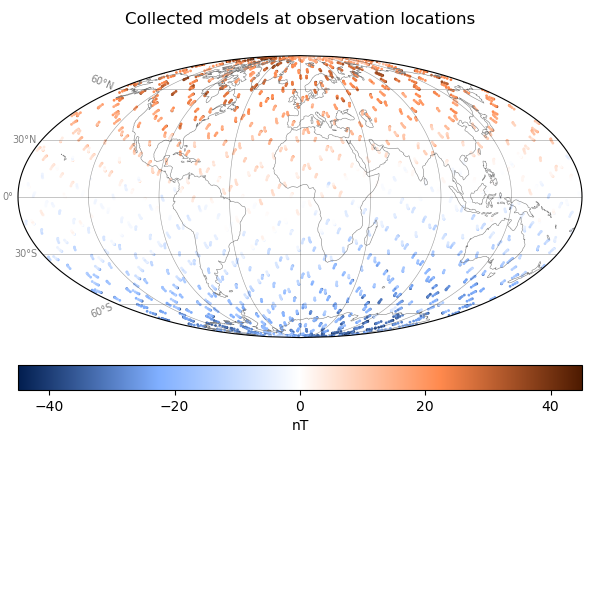

In [16]:
mt_util.plot_global(lat = ds.Latitude.values, lon = ds.Longitude.values, data=ds["B_NEC_M_use"].values[:,2], 
                cbar_h = 0.075, cbar_mm_factor = 2/3, unit_transform_n_to_m = False,
                cbar_text = "nT", figsize=(6,6), coast_width = 0.4,
                bottom=0.35, top=0.95, hspace=0.01,
                title='Collected models at observation locations', point_size=1,
                savefig = False, save_dpi = 100, save_string ="vre_obs",
                use_gridlines = True, gridlines_width = 0.4, gridlines_alpha = 0.4)

In [17]:
SZA_angle = 10
Kp_max = 2
dDst_max = 2
QDlat_max = 55

idx_sort = np.logical_and.reduce((np.abs(ds.SunZenithAngle.values)>SZA_angle, ds.Kp.values<=Kp_max, abs(ds.QDLat.values)<QDlat_max, abs(np.diff(ds.Dst.values,prepend=0))/(5/60) <=dDst_max))

In [18]:
obs_sat = SDSS(comment, N_SH = shn)

obs_sat.data = -ds["B_NEC"].values[:,2][idx_sort] + ds["B_NEC_M_use"].values[:,2][idx_sort] 

obs_sat.r_grid = np.array(ds.Radius[idx_sort])/10**3
obs_sat.lon = np.array(ds.Longitude[idx_sort])
obs_sat.lat = np.array(ds.Latitude[idx_sort])
obs_sat.grid_N = len(obs_sat.data)

In [19]:
print(obs_sat)


______current attributes______

a:                6371.2
r_sat:            6721.2
r_cmb:            3480.0
rad:              0.017453292519943295
mu0:              1.2566370614359173e-06
comment:          Showcase VRE workflow with SDSSIM
class_abs_path:   /home/mikotz/spherical_direct_sequential_simulation
N_SH:             30
N_SH_secondary:   None
sim_type:         core
data:             (838,), Max/Min: 47630.39 / -47221.32
r_grid:           (838,), Max/Min: 6834.01 / 6817.42
lon:              (838,), Max/Min: 178.90 / -178.43
lat:              (838,), Max/Min: 59.57 / -68.45
grid_N:           838



<IPython.core.display.Javascript object>


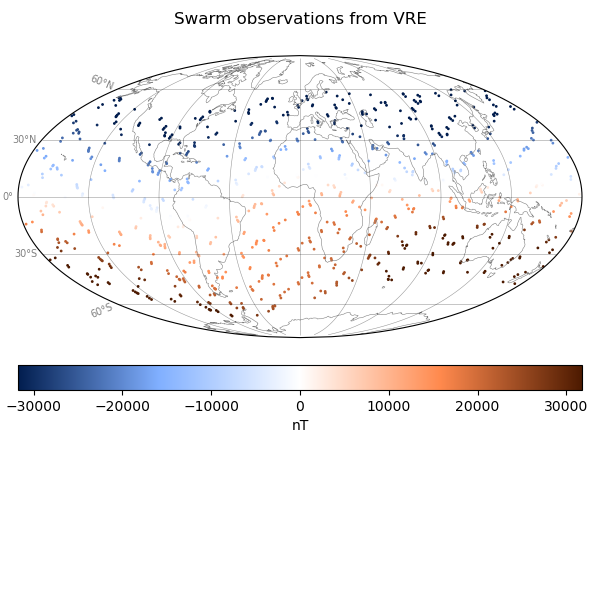

In [20]:
mt_util.plot_global(lat = obs_sat.lat, lon = obs_sat.lon, data=obs_sat.data, 
                cbar_h = 0.075, cbar_mm_factor = 2/3, unit_transform_n_to_m = False,
                cbar_text = "nT", figsize=(6,6), coast_width = 0.4,
                bottom=0.35, top=0.95, hspace=0.01,
                title='Swarm observations from VRE', point_size=1,
                savefig = False, save_dpi = 100, save_string ="vre_obs",
                use_gridlines = True, gridlines_width = 0.4, gridlines_alpha = 0.4)

# Kernel

In [21]:
core.grid_glq(nmax = shn, r_at = core.r_cmb)
core.integrating_kernel(obs_sat, C_e_const = C_e_const)

# Equivalent LSQ

In [22]:
core.covmod_lsq_equiv(obs_sat.data, core.C_mm_all, core.G, core.r_cmb)

<IPython.core.display.Javascript object>


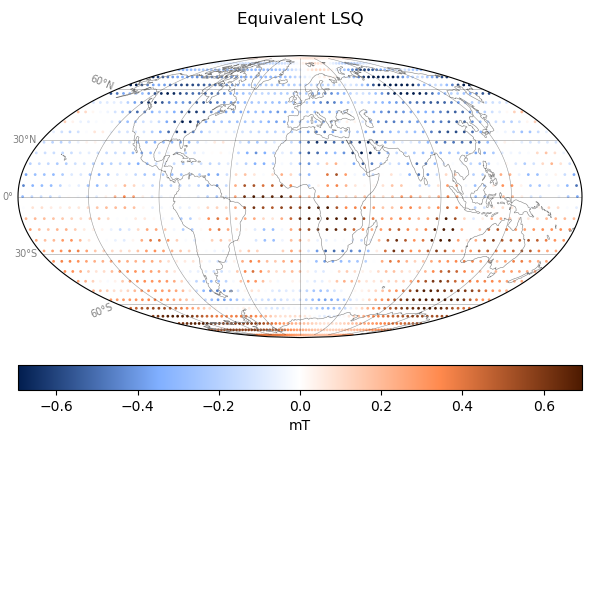

In [23]:
mt_util.plot_global(lat = core.lat, lon = core.lon, data=np.ravel(core.m_equiv_lsq), 
                cbar_h = 0.075, cbar_mm_factor = 2/3, unit_transform_n_to_m = True,
                cbar_text = "mT", figsize=(6,6), coast_width = 0.4,
                bottom=0.35, top=0.95, hspace=0.01,
                title='Equivalent LSQ', point_size=1,
                savefig = False, save_dpi = 100, save_string ="vre_obs_lsq",
                use_gridlines = True, gridlines_width = 0.4, gridlines_alpha = 0.4)

In [24]:
core.grid_glq(nmax = 256, r_at = core.r_cmb)
core.ensemble_B(core.g_lsq_equiv, nmax = shn, r_at = core.r_cmb, grid_type = "glq")
lsq_eqa_m_use = core.B_ensemble[:,0].copy()

In [25]:
core.grid_glq(nmax = shn, r_at = core.r_cmb)

obs_sat.data = -ds["B_NEC"].values[:,2][idx_sort] #+ ds["B_NEC_M_use"].values[:,2][idx_sort] 

core.covmod_lsq_equiv(obs_sat.data, core.C_mm_all, core.G, core.r_cmb)
core.grid_glq(nmax = 256, r_at = core.r_cmb)
core.ensemble_B(core.g_lsq_equiv, nmax = shn, r_at = core.r_cmb, grid_type = "glq")
lsq_eqa = core.B_ensemble[:,0].copy()

<IPython.core.display.Javascript object>


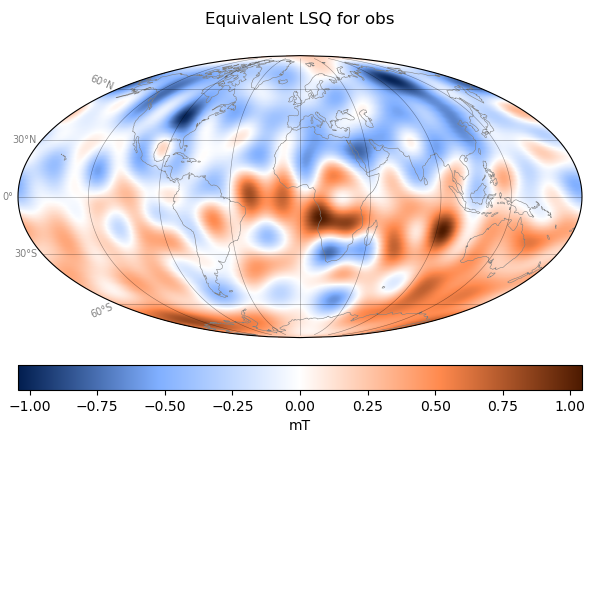

<IPython.core.display.Javascript object>


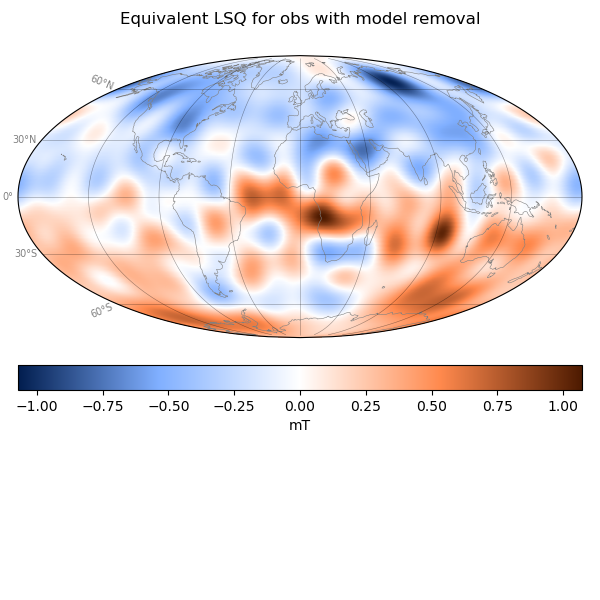

In [26]:
mt_util.plot_global(lat = 90-core.grid_theta, lon = core.grid_phi, data=lsq_eqa, 
                cbar_h = 0.075, cbar_mm_factor = 3/3, unit_transform_n_to_m = True,
                cbar_text = "mT", figsize=(6,6), coast_width = 0.4,
                bottom=0.35, top=0.95, hspace=0.01,
                title='Equivalent LSQ for obs', point_size=1,
                savefig = False, save_dpi = 100, save_string ="vre_obs_lsq",
                use_gridlines = True, gridlines_width = 0.4, gridlines_alpha = 0.4)

mt_util.plot_global(lat = 90-core.grid_theta, lon = core.grid_phi, data=lsq_eqa_m_use, 
                cbar_h = 0.075, cbar_mm_factor = 3/3, unit_transform_n_to_m = True,
                cbar_text = "mT", figsize=(6,6), coast_width = 0.4,
                bottom=0.35, top=0.95, hspace=0.01,
                title='Equivalent LSQ for obs with model removal', point_size=1,
                savefig = False, save_dpi = 100, save_string ="vre_obs_lsq",
                use_gridlines = True, gridlines_width = 0.4, gridlines_alpha = 0.4)

 |OOOOOOOOOO| 100.0%   realization nr. 0. Counter: 1891/1891, Running error magnitude: 5.4
Run time: 2.228 minutes 
Total elapsed time: 2.228 minutes 
Variance: 156536382746.228
Mean: 11910.648
Max: 2644337.822
Min: -1568382.880
Run nr.: 1

 |OOOOOOOOOO| 100.0%   realization nr. 1. Counter: 1891/1891, Running error magnitude: 5.4
Run time: 2.215 minutes 
Total elapsed time: 4.444 minutes 
Variance: 152359589006.441
Mean: 9024.726
Max: 1444912.419
Min: -1298473.715
Run nr.: 2

 |OOOOOOOOOO| 100.0%   realization nr. 2. Counter: 1891/1891, Running error magnitude: 5.4
Run time: 2.194 minutes 
Total elapsed time: 6.638 minutes 
Variance: 150570546557.609
Mean: 14331.757
Max: 1159317.329
Min: -1661856.928
Run nr.: 3

 |OOOOOOOOOO| 100.0%   realization nr. 3. Counter: 1891/1891, Running error magnitude: 5.4
Run time: 2.125 minutes 
Total elapsed time: 8.763 minutes 
Variance: 150729726062.695
Mean: 13556.940
Max: 2430165.121
Min: -1145401.290
Run nr.: 4

 |OOOOOOOOOO| 100.0%   realization nr

<IPython.core.display.Javascript object>


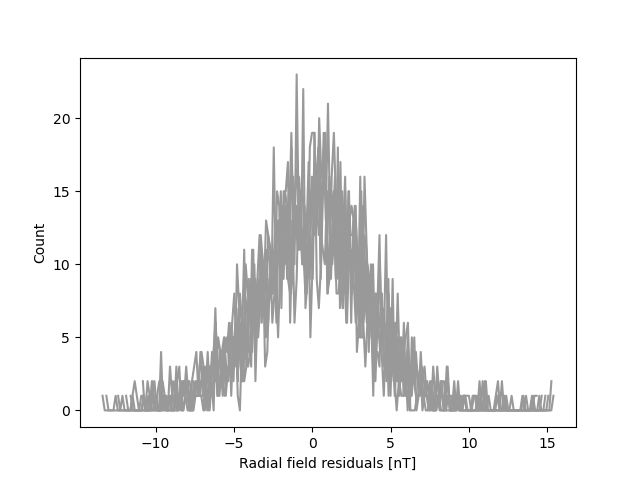

In [27]:
core.grid_glq(nmax = shn, r_at = core.r_cmb)

N_sim = 6

core.run_sim(N_sim, core.grid_N, core.C_mm_all, core.C_dd, core.C_dm_all, core.G,
        obs_sat.data, core.data, scale_m_i = True, unit_d = False, collect_all = False,
        sense_running_error = True, save_string = nb_name, sim_stochastic = False, solve_cho = True)

In [28]:
core.realization_to_sh_coeff(core.r_cmb, set_nmax = shn)

# Evaluation

<IPython.core.display.Javascript object>


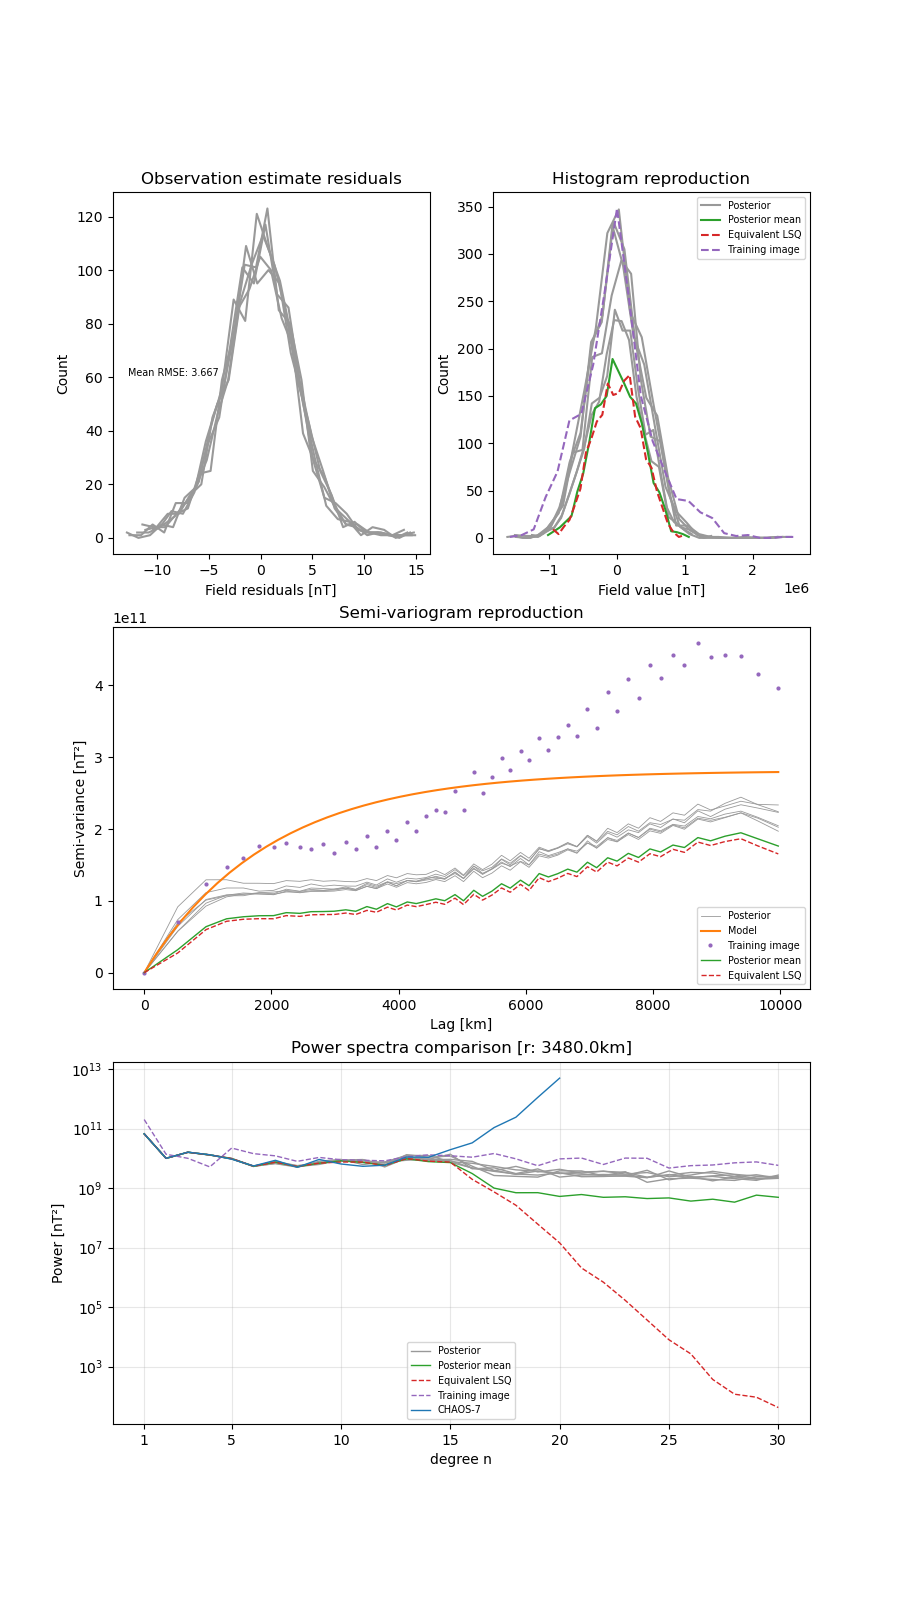

In [29]:
# Reload plot module when making small changes
import importlib
importlib.reload(mt_util)

core.grid_glq(nmax = shn, r_at = core.r_cmb)
mt_util.plot_sdssim_reproduce(core, core.m_DSS_res, m_equiv_lsq = core.m_equiv_lsq, truth_obj = None,
                              lags_use = 1000, spec_r_at = core.r_cmb, spec_show_differences = False,
                              model_dict = {"CHAOS-7"}, figsize=(9,16), spec_chaos_time = [2016,1,1],
                              hist_bins = 25, res_bins = 25,
                              savefig = False, save_string = "vre_obs", save_dpi = 300)

In [30]:
core.grid_glq(nmax = 256, r_at = core.r_cmb)

set_nmax = shn

core.ensemble_B(core.g_spec, nmax = set_nmax, r_at = core.r_cmb, grid_type = "glq")
zs_eqa = core.B_ensemble[:,0,:].copy()

#core.g_spec_mean = np.mean(core.g_spec,axis=1)
core.ensemble_B(core.g_spec_mean, nmax = set_nmax, r_at = core.r_cmb, grid_type = "glq")
zs_mean_eqa = core.B_ensemble[:,0].copy()

core.ensemble_B(core.g_prior[:mt_util.shc_vec_len(set_nmax)], nmax = set_nmax, r_at = core.r_cmb, grid_type = "glq")
prior_eqa = core.B_ensemble[:,0].copy()

core.ensemble_B(core.g_lsq_equiv, nmax = set_nmax, r_at = core.r_cmb, grid_type = "glq")
lsq_eqa = core.B_ensemble[:,0].copy()

<IPython.core.display.Javascript object>


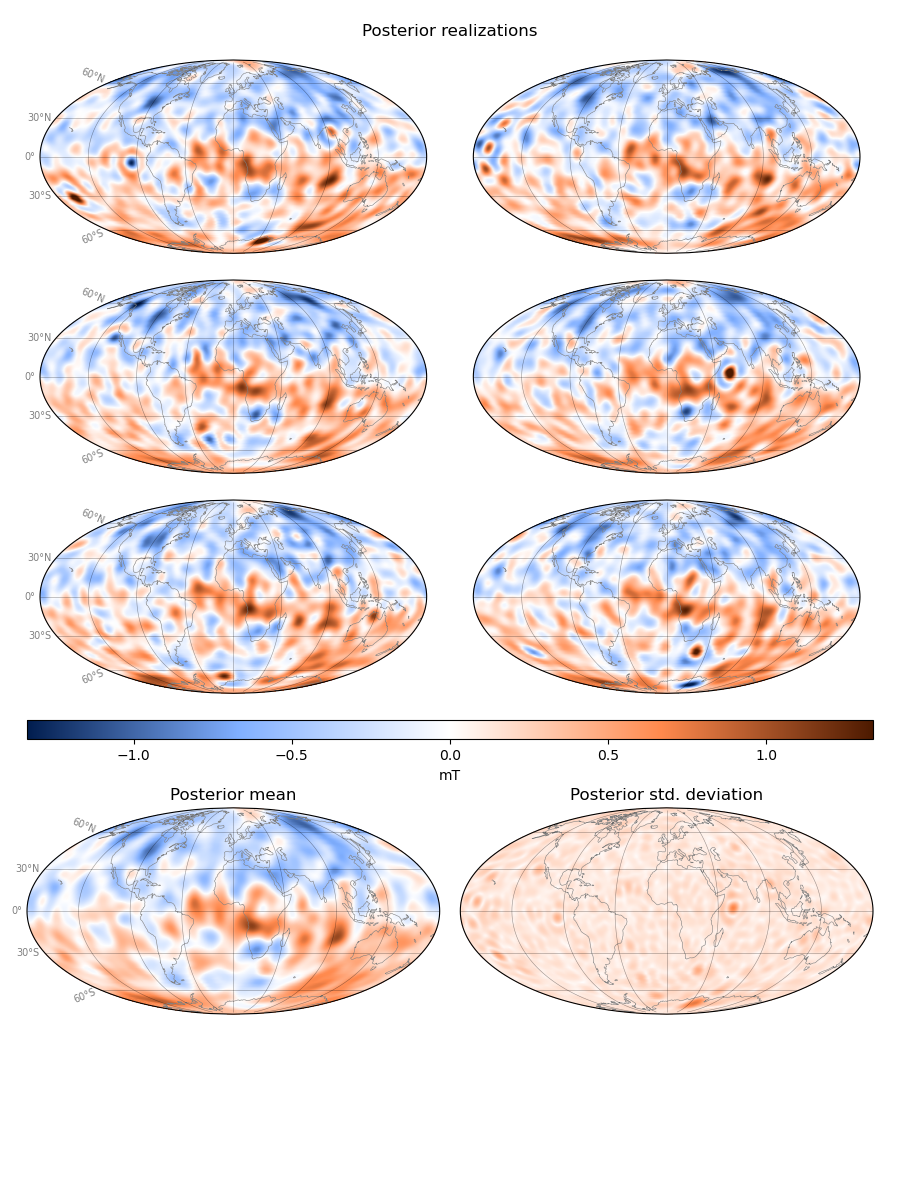

In [32]:
# Reload plot module when making small changes
import importlib
importlib.reload(mt_util)
# ccrs.PlateCarree()
# ccrs.Mollweide()
# ccrs.Orthographic(central_longitude=0.0, central_latitude=0.0)

mt_util.plot_ensemble_map_tiles(core.grid_phi, 90-core.grid_theta, zs_eqa, 
                        field_mean = zs_mean_eqa,
                        tile_size_row = 4, tile_size_column = 2, 
                        figsize=(9,12), limit_for_SF = 10**6, point_size = 10, cbar_mm_factor = 2/3,
                        coast_width = 0.4, coast_color = "grey", unit_transform_n_to_m = True,
                        cbar_h = 0.1, cbar_text = "mT", cbar_text_color = "black",
                        left=0.03, bottom=0.12, right=0.97, top=0.95, wspace = 0.05, hspace=0.15, 
                        savefig = False, save_string = "vre_obs", 
                        projection = ccrs.Mollweide(), use_gridlines = True, 
                        gridlines_width = 0.4, gridlines_alpha = 0.4, save_dpi = 100)
